#**load libraries**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import datetime
import matplotlib.pyplot as plt
from shapely.wkt import loads as wkt_loads
import tifffile as tiff

from keras import backend as K
from sklearn.metrics import jaccard_similarity_score

from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import gc
import warnings
warnings.filterwarnings("ignore")
from keras.models import load_model
import tensorflow as tf
import random as rn
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tqdm import tqdm

In [ ]:
path = '/content/SI'
os.mkdir(path)
os.mkdir(path+'/data')
os.mkdir(path+'/msk')
os.mkdir(path+'/weights')
os.mkdir(path+'/subm')

In [ ]:
path = '/content/SI/data'
os.mkdir(path+'/x_tr_a')
os.mkdir(path+'/x_tr_na')
os.mkdir(path+'/y_tr_a')
os.mkdir(path+'/y_tr_na')

os.mkdir(path+'/x_val_a')
os.mkdir(path+'/x_val_na')
os.mkdir(path+'/y_val_a')
os.mkdir(path+'/y_val_na')

os.mkdir(path+'/x_test_a')
os.mkdir(path+'/x_test_na')
os.mkdir(path+'/y_test_a')
os.mkdir(path+'/y_test_na')


In [ ]:
num_cls = 10
size = 160
smooth = 1e-12

TR = pd.read_csv('/content/train_wkt_v4.csv')
GS = pd.read_csv('/content/grid_sizes.csv')

#SF = pd.read_csv('/content/sample_submission.csv')
GS = GS.rename( columns={'Unnamed: 0':'ImageId'}) #rename 'ImageId'

#**preprocessing**

In [ ]:
#https://www.kaggle.com/aamaia/rgb-using-m-bands-example

def adjust_contrast(bands, lower_percent=2, higher_percent=98):
    """
    to adjust the contrast of the image 
    bands is the image 
    """
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [ ]:
def coordi_to_raster(coords, img_size, xmax, ymax):
    """
    converts coordinates(polygons) to raster(pixels).
    """
  
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / xmax
    yf = H1 / ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

def convert_contours(polygonList, raster_img_size, xmax, ymax):
    """
    Returns exterior and interior coords of the given multipolygon,
    which are then used to create image masks with multipolygon objects.
    """
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = coordi_to_raster(perim, raster_img_size, xmax, ymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = coordi_to_raster(interior, raster_img_size, xmax, ymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def generate_mask_for_image_and_class(raster_size, image_id, class_type):

    """
    returns generated image_mask using img_size(raster_size), image_id and class_type.
    """
    xmax, ymax = GS[GS.ImageId == image_id].iloc[0, 1:].astype(float)

    df_image = TR[TR.ImageId == image_id]
    multipoly_def = df_image[df_image.ClassType == class_type].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    
    contours = convert_contours(polygonList, raster_size, xmax, ymax)

    img_mask = np.zeros(raster_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, 1)
    cv2.fillPoly(img_mask, interior_list, 0)

    return img_mask

In [ ]:

def get_patches(img, msk, name1, name2, name3, name4, amt, aug=True):

    """
    returns image pathces(crops) of given image and mask
    patch_size = 160*160
    """

    random.seed(42)
    is2 = int(1.0 * size)

    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    a, b , c, d = [], [], [], []

    # thresholds for each class to get patches
    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    
    xyz = np.ceil(amt*0.10).astype(int)
    amt1 = amt-xyz
    amt2 = xyz

   # to get augmented data
    for i in range(amt1):

        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

     
        for j in range(num_cls):
            sm = np.sum(ms[:, :, j])

            if 1.0 * sm / is2 ** 2 > tr[j]:
               
                #augmentation
                if aug:
                    
                    # reversing
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]

                    #flipping 
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]
                    rotation = np.random.randint(4) # 0, 1, 2, 3

                    #transpose & rotation
                    if random.uniform(0, 1) > 0.5:
                       im = np.rot90(im.transpose((1,0,2)), k=rotation)
                       ms = np.rot90(ms.transpose((1,0,2)), k=rotation)
                    
                    #rotation
                    if random.uniform(0, 1) > 0.5:
                      im = np.rot90(im, k=rotation)
                      ms = np.rot90(ms, k=rotation)
                    
                    #shearing 
                    if random.uniform(0, 1) > 0.5:
                       im = tf.keras.preprocessing.image.apply_affine_transform(im, shear=0)
                       im = tf.keras.preprocessing.image.apply_affine_transform(im, shear=0)
                                     
                
                im = im.astype(np.float16)
                ms = ms.astype(np.float16)
                
                
                np.save("/content/SI/data/{}/{}".format(name1, i),im)  
                np.save("/content/SI/data/{}/{}".format(name2, i),ms)  
               
                a.append("/content/SI/data/{}/{}.npy".format(name1, i))
                b.append("/content/SI/data/{}/{}.npy".format(name2, i))

    # to get non-augmented data
    for i in range(amt2):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        im = im.astype(np.float16)
        ms = ms.astype(np.float16)
                                  
        np.save("/content/SI/data/{}/{}".format(name3, i),im)  
        np.save("/content/SI/data/{}/{}".format(name4, i),ms)  
                
        c.append("/content/SI/data/{}/{}.npy".format(name3, i))
        d.append("/content/SI/data/{}/{}.npy".format(name4, i))

    
    print(len(a), len(b))
    print(len(c), len(d))
  
    return a+c, b+d

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        #print(len(batch))
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

class Dataset:
  
    def __init__(self, images_dir, mask_dir):
        
        self.ids = images_dir
        self.images_fps = images_dir
        self.masks_fps  = mask_dir
    
    def __getitem__(self, i):
        
        # read data
        image = np.load(self.images_fps[i]) 
        mask  = np.load(self.masks_fps[i])

          
        image = np.stack(image, axis=-1).astype('float')
        mask = np.stack(mask, axis=-1).astype('float')

        #image = np.transpose(image, (1,0,2)) 
        #mask = np.transpose(mask, (1,0,2)) 
    
        image = np.transpose(image, (0,2,1)) 
        mask = np.transpose(mask, (0,2,1)) 
  
        return image, mask
      
    def __len__(self):
        return len(self.ids)        

In [ ]:

print ("let's combine all imgs together")
s = 835

X = np.zeros((5 * s, 5 * s, 8))
Y = np.zeros((5 * s, 5 * s, num_cls))  

ids = sorted(set(TR.ImageId))
print (len(ids))

for i in range(5):
    for j in range(5):
        id = ids[5 * i + j]

        #Read 16-band image
        rgb_img = os.path.join( 'sixteen_band', '{}_M.tif'.format(id))      
        rgb_img = tiff.imread(rgb_img)
        rgb_img = np.rollaxis(rgb_img, 0, 3)     
        img = adjust_contrast(rgb_img).copy()
        
        print (img.shape, id)
        X[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
        for z in range(num_cls):
            Y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

np.save('/content/SI/data/X', X)
np.save('/content/SI/data/Y', Y)
print(X.shape)
print(Y.shape)

let's combine all imgs together
25
(837, 849, 8) 6010_1_2
(837, 849, 8) 6010_4_2
(837, 848, 8) 6010_4_4
(837, 848, 8) 6040_1_0
(837, 848, 8) 6040_1_3
(837, 848, 8) 6040_2_2
(837, 846, 8) 6040_4_4
(837, 851, 8) 6060_2_3
(838, 835, 8) 6070_2_3
(837, 848, 8) 6090_2_0
(837, 848, 8) 6100_1_3
(837, 848, 8) 6100_2_2
(837, 848, 8) 6100_2_3
(837, 849, 8) 6110_1_2
(837, 849, 8) 6110_3_1
(837, 849, 8) 6110_4_0
(837, 851, 8) 6120_2_0
(837, 851, 8) 6120_2_2
(837, 849, 8) 6140_1_2
(837, 849, 8) 6140_3_1
(837, 851, 8) 6150_2_3
(837, 848, 8) 6160_2_1
(837, 848, 8) 6170_0_4
(837, 848, 8) 6170_2_4
(837, 848, 8) 6170_4_1
(4175, 4175, 8)
(4175, 4175, 10)


#**split the data into train, val and test**

In [ ]:
x_trn, y_trn = get_patches(X, Y, 'x_tr_a', 'y_tr_a', 'x_tr_na', 'y_tr_na', 20000, aug=True)

6262 6262
2000 2000


In [ ]:
x_val, y_val = get_patches(X, Y, 'x_val_a', 'y_val_a', 'x_val_na', 'y_val_na', 4000, aug=True)

1246 1246
400 400


In [ ]:
x_test, y_test = get_patches(X, Y, 'x_test_a', 'y_test_na', 'x_test_a', 'y_test_na', 4000, aug=True)

1246 1246
400 400


In [ ]:
train_dataset = Dataset(x_trn, y_trn)
train_dataloader = Dataloder(train_dataset, batch_size=8)
val_dataset = Dataset(x_val, y_val)
val_dataloader = Dataloder(val_dataset, batch_size=8)

In [ ]:
train_dataloader[0][0].shape

(8, 160, 160, 8)

#**modeling**

In [ ]:
def jaccard_coef(y_true, y_pred):
    """
    Jaccard Index: Intersection over Union.
    J(A,B) = |A∩B| / |A∪B| 
         = |A∩B| / |A|+|B|-|A∩B|
    """
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    total = K.sum(y_true + y_pred, axis=[0, -1, -2])
    union = total - intersection

    jac = (intersection + smooth) / (union+ smooth)

    return K.mean(jac)

#**unet model**

In [ ]:

#https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras


##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)


def get_unet():


    inputs = Input((8, size, size))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 23),data_format='channels_first')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 43),data_format='channels_first')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 26),data_format='channels_first')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_uniform(seed= 45),data_format='channels_first')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 54),data_format='channels_first')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 25),data_format='channels_first')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 63),data_format='channels_first')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_uniform(seed= 32),data_format='channels_first')(conv4)
    drop4 = Dropout(0.5, seed= 38)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(drop4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 32),data_format='channels_first')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 27),data_format='channels_first')(conv5)
    drop5 = Dropout(0.5, seed = 41)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 28),data_format='channels_first')(UpSampling2D(size = (2,2),data_format='channels_first')(drop5))
    merge6 = concatenate([drop4,up6], axis = 1)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 39),data_format='channels_first')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 21),data_format='channels_first')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 11),data_format='channels_first')(UpSampling2D(size = (2,2),data_format='channels_first')(conv6))
    merge7 = concatenate([conv3,up7], axis = 1)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 17),data_format='channels_first')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 53),data_format='channels_first')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 63),data_format='channels_first')(UpSampling2D(size = (2,2),data_format='channels_first')(conv7))
    merge8 = concatenate([conv2,up8], axis = 1)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 29),data_format='channels_first')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 22),data_format='channels_first')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 54),data_format='channels_first')(UpSampling2D(size = (2,2),data_format='channels_first')(conv8))
    merge9 = concatenate([conv1,up9], axis = 1)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 67),data_format='channels_first')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 56),data_format='channels_first')(conv9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = tf.keras.initializers.he_normal(seed= 64),data_format='channels_first')(conv9)
    conv10 = Conv2D(num_cls, (1, 1),strides=1, activation = 'sigmoid',data_format='channels_first')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy', metrics=[jaccard_coef])
    print(model.output.shape)

    return model


#**segnet model**

In [ ]:

##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

def SegNet():
    
    tf.random.set_seed(32)
    classes= 10
    img_input = Input(shape=(size, size, 8))
    x = img_input

    # Encoder 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 23))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',  kernel_initializer = tf.keras.initializers.he_normal(seed= 43))(x)
   # x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 32))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 41))(x)
   # x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 33))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.5)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 35))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 54))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 39))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    #Decoder
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 45))(x)
   # x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 41))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 49))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
      
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 18))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 21))(x)
    x = BatchNormalization()(x)
    x = Conv2D(classes, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 16))(x)
    x = Dropout(0.25)(x)
  
    x = Activation("softmax")(x)
    
    model = Model(img_input, x)
  
    model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy', metrics=[jaccard_coef])
    return model

In [ ]:
def changeLearningRate(epoch):

    #lr=0.001
    lr=0.0001
    if epoch > 10 and epoch <=20:
      lr*=0.1
    elif epoch > 20 and epoch <=30:
      lr*=0.01
    elif epoch > 30 and epoch <=40:
      lr*=0.001
    elif epoch > 40 and epoch <=50:  
      lr*=0.0001
    elif epoch > 50 and epoch <=60:  
      lr*=0.0001  
    elif epoch > 60:
      lr*=0.0001

    return lr    

In [ ]:
#https://towardsdatascience.com/neural-network-with-tensorflow-how-to-stop-training-using-callback-5c8d575c18a9

ACCURACY_THRESHOLD=0.502
class myCallback(tf.keras.callbacks.Callback): 
    
    def on_epoch_end(self, epoch, logs={}): 
        if (logs.get('val_jaccard_coef') > ACCURACY_THRESHOLD) and (logs.get('jaccard_coef') > ACCURACY_THRESHOLD):   #and ((logs.get('accuracy')-logs.get('val_accuracy'))<=5):
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

stop = myCallback()   

In [ ]:
filepath="/content/model_weights/weights-{epoch:02d}-{val_jaccard_coef:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [ ]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose = 1, min_delta = 0.0001)
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)
#call_list = [checkpoint, lrschedule, rlrop, stop]


In [ ]:
model = SegNet()

In [ ]:
history = model.fit(train_dataloader, 
                              steps_per_epoch=len(train_dataloader),
                              epochs=60,
                              validation_data=val_dataloader, callbacks=checkpoint
                              )

#**prediction**

In [ ]:
test_dataset = Dataset(x_test, y_test)
test_dataloader = Dataloder(test_dataset, batch_size=1)


In [ ]:
model = SegNet()
model.load_weights("/content/model_weights/weights-59-0.4575.hdf5")

In [ ]:
Score= []
for i in tqdm(range(len(test_dataloader))):
   pred_msk = model.predict(test_dataloader[i][0])
   score = jaccard_coef(test_dataloader[i][1], pred_msk)
   Score.append(score)


100%|██████████| 51/51 [00:26<00:00,  1.89it/s]


In [ ]:
score = sum(Score)/len(test_dataloader)
print("The score on test data is", score.numpy())

The score on test data is 0.44639628886775934


#**error analysis**

In [ ]:
model = SegNet()
model.load_weights("/content/weights-59-0.4575.hdf5")

In [ ]:
total_x = x_trn + x_val + x_test
total_y = y_trn + y_val+ y_test

In [ ]:
total_dataset = Dataset(total_x, total_y)
total_dataloader = Dataloder(total_dataset, batch_size=1)

In [ ]:
Score= []
very_low_jaccard=[]
medium_jaccard= []
very_high_jaccard= []

for i in tqdm(range(len(total_dataloader))):

   pred_msk = model.predict(total_dataloader[i][0])
   score = jaccard_coef(total_dataloader[i][1], pred_msk)
   
   if score>0 and score <=0.20:
      very_low_jaccard.append(i)

   elif score>0.20 and score <=0.70:
      medium_jaccard.append(i)
   
   elif score>0.70 and score <=1:
      very_high_jaccard.append(i)

100%|██████████| 11554/11554 [12:24<00:00, 15.51it/s]


In [ ]:
Very_low_jaccard_x = []
Medium_jaccard_x = []
Very_high_jaccard_x = []

Very_low_jaccard_y = []
Medium_jaccard_y = []
Very_high_jaccard_y = []

for i in very_low_jaccard:
   Very_low_jaccard_x.append(total_x[i])
for i in medium_jaccard:
   Medium_jaccard_x.append(total_x[i])
for i in very_high_jaccard:
   Very_high_jaccard_x.append(total_x[i])      

for i in very_low_jaccard:
   Very_low_jaccard_y.append(total_y[i])
for i in medium_jaccard:
   Medium_jaccard_y.append(total_y[i])
for i in very_high_jaccard:
   Very_high_jaccard_y.append(total_y[i])       


In [ ]:
np.save("vljx", Very_low_jaccard_x)
np.save("vljy", Very_low_jaccard_y)

In [ ]:
vljx = np.load("/content/vljx.npy")
vljy = np.load("/content/vljy.npy")

In [ ]:
#https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras

def mask_to_polygons(mask, epsilon=5, min_area=1.):
    """
    converts a mask into polygons.
    """
    
    contours, hierarchy = cv2.findContours(((mask == 1) * 255).astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()

    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1

    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])

    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons


In [ ]:
DF  = pd.DataFrame(columns=["image", "class", "poly"])

for i in range(25):
   abcd = np.load(vljy[i])
   image, cl , ploy = [],[],[]
  
   for j in range(10):
     ab = mask_to_polygons(abcd[:,:,j], epsilon=1)
     image.append(i+1)
     cl.append(j+1)
     poly.append(len(ab))
     df = pd.DataFrame(list(zip(image, cl, poly)), columns = ['image', 'class', 'poly'])

   DF = pd.concat([DF,df], ignore_index=True)

In [ ]:
objects_per_image = DF.pivot(index='class', columns='image', values='poly')
#objects_per_image.T

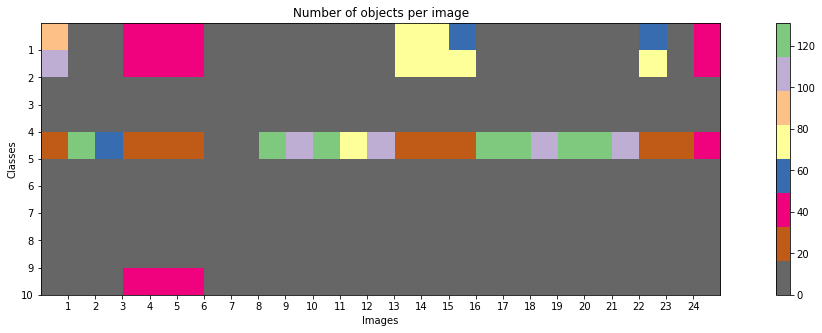

In [ ]:
%matplotlib inline
figure, axis = plt.subplots(figsize=(20, 5))
axis.set_aspect('equal')
plt.imshow(objects_per_image.astype(np.uint), cmap='Accent_r', extent=[0, 25, 10, 0])

plt.xticks(np.arange(1, 25, 1.0))
plt.yticks(np.arange(1, 11, 1.0))
plt.title('Number of objects per image')
plt.xlabel('Images')
plt.ylabel('Classes')
plt.colorbar()
plt.show()

**Observations**

1. classes 2,3,4, 6, 7, 8, and 9 are totally absent.
2. Only few images have class 10.
3. class 4 is almost present in all images.


In [ ]:
print("minimum value in an image",np.amin(np.load(vljx[0])))
print("maximum value in an image",np.amax(np.load(vljx[0])))

minimum value in an image 0.0
maximum value in an image 1.0


In [ ]:
threshold = 0.4
Sum = []

for i in tqdm(range(25)):
   a = np.load(vljx[i])
   im= []
   for j in range(8):
     im.append(np.count_nonzero(np.less(a[:,:,j], threshold))) 
   x = sum(im)
   Sum.append(x)  
percentage = (sum(Sum)/(160*160*8*25))*100 

100%|██████████| 25/25 [00:00<00:00, 335.95it/s]


In [ ]:
print("percenatge of values less than threshold 0.4 is", percentage)

percenatge of values less than threshold 0.4 is 57.066874999999996


**observations**

1. Percenatge of values less than threshold 0.4 is 57.066874999999996.
2. More values less than taken threshold value implies that image brightness is not so good.


**some very low jaccard score images and their masks**

In [ ]:
def plot_image(image_id):

  m = np.load(vljx[image_id])
  m = adjust_contrast(m)
  img = np.zeros((m.shape[0],m.shape[1],3))
  img[:,:,0] = m[:,:,4] #red
  img[:,:,1] = m[:,:,2] #green
  img[:,:,2] = m[:,:,1] #blue
  #plt.figure(figsize=(7,7))
  plt.imshow(img, interpolation='nearest')
  plt.show()

In [ ]:
def plot_mask(mask_id):
  m = np.load(vljy[i])
  m = adjust_contrast(m)
  img = np.zeros((m.shape[0],m.shape[1],3)) 
  img[:,:,0] = m[:,:,4] #red
  img[:,:,1] = m[:,:,2] #green
  img[:,:,2] = m[:,:,1] #blue
  #plt.figure(figsize=(7,7))
  plt.imshow(img, interpolation='nearest')
  plt.show()

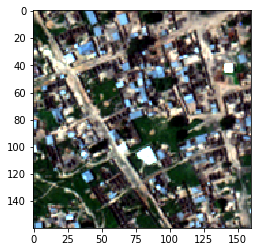

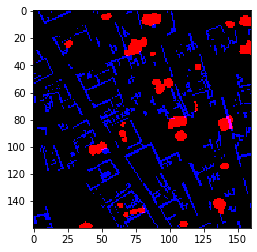

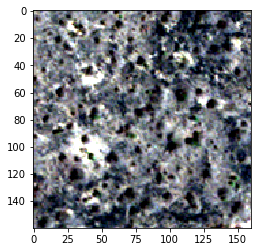

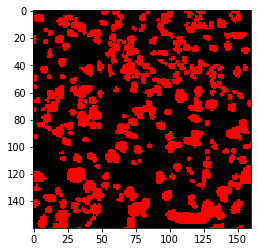

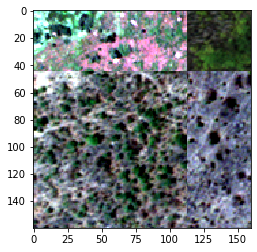

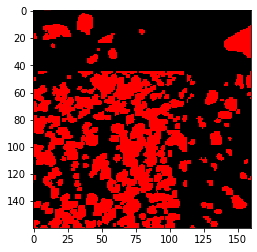

In [ ]:
for i in range(3):
   plot_image(i)
   plot_mask(i)